# RDD Exercise

Create an example of an RDD (Regression Discontinuity Design) where $X = \mathbb{1}(Z > 0)$ and $\mathbb{E}\left[Y |do(X = 1), Z\right]$ and $\mathbb{E}\left[Y |do(X = 0), Z\right]$ are not linear in $Z$. Compare the CACE (Conditional Average Causal Effect) estimates using linear regression and some non-parametric regression method. Discuss, in a general sense, the performance of linear regression in this case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# E(Y | do(X), Z) are continuous, so we are in the hypotheses of the RDD method.

def ground_truth_X_false(Z):
    """E(Y | do(X=0), Z)."""
    return np.sin(Z)

def ground_truth_X_true(Z):
    """E(Y | do(X=1), Z)."""
    return np.cos(np.pi * Z)

def generate_truth_X_Z(X, Z):
    """E(Y | do(X), Z)."""
    return np.select([X, ~X], [ground_truth_X_true(Z), ground_truth_X_false(Z)])

def generate_noise(size, random_state=None):
    """Zero mean random noise."""
    return np.random.RandomState(random_state).normal(0, 0.3, size=size)

def generate_data(size, z1, random_state=None):
    """Data generation process."""
    rs = np.random.RandomState(random_state).randint(0, 2**32 - 1, size=2, dtype=np.int64)
    Z = np.random.RandomState(rs[0]).normal(0, 1, size=size)
    X = (Z > z1)
    Y = generate_truth_X_Z(X, Z) + generate_noise(size=size, random_state=rs[1])
    return Z, X, Y

In [3]:
size = 500
z1 = 0.2
Z, X, Y = generate_data(size=size, z1=z1, random_state=42)

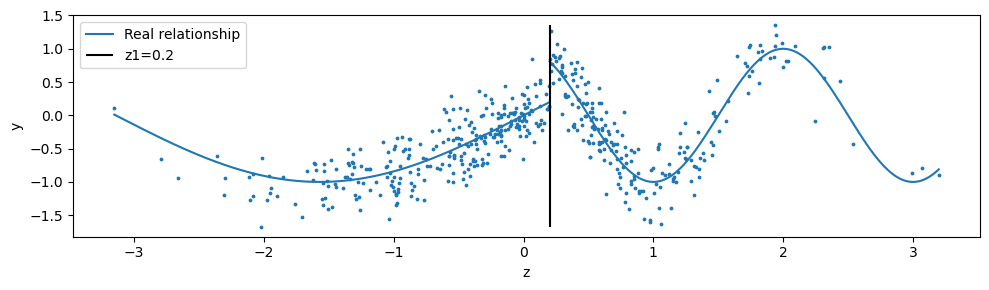

In [4]:
min_Z, max_Z = min(Z), max(Z)
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(Z, Y, s=3)
plot_Z = np.linspace(min_Z, max_Z, 1001)
plot_X = (plot_Z > z1)
plot_Y = generate_truth_X_Z(plot_X, plot_Z)
ax.plot(plot_Z[plot_X], plot_Y[plot_X], "C0", label="Real relationship")
ax.plot(plot_Z[~plot_X], plot_Y[~plot_X], "C0")
ax.vlines(z1, min(Y), max(Y), "k", label=f"{z1=}")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold

In [6]:
lr_X_false = LinearRegression().fit(Z[~X].reshape(-1, 1), Y[~X])
lr_X_true = LinearRegression().fit(Z[X].reshape(-1, 1), Y[X])

In [7]:
rfr_X_false = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    cv=KFold(shuffle=True, random_state=42),
    param_grid={"max_depth": [2, 3, 4, 5, 8, 10]}
).fit(Z[~X].reshape(-1, 1), Y[~X])

rfr_X_true = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    cv=KFold(shuffle=True, random_state=42),
    param_grid={"max_depth": [2, 3, 4, 5, 8, 10]}
).fit(Z[X].reshape(-1, 1), Y[X])

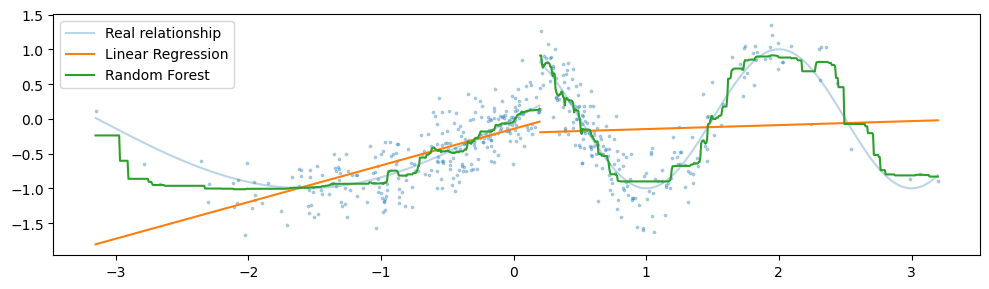

In [8]:
def plot(X, model, ax, c, label=None):
    ax.plot(plot_Z[X], model.predict(plot_Z[X].reshape(-1, 1)), c, label=label)

fig, ax = plt.subplots(figsize=(10, 3))

ax.scatter(Z, Y, s=3, alpha=0.3)

# Real relationship
ax.plot(plot_Z[plot_X], plot_Y[plot_X], "C0", alpha=0.3, label="Real relationship")
ax.plot(plot_Z[~plot_X], plot_Y[~plot_X], "C0", alpha=0.3)

# Random Forest
plot(~plot_X, lr_X_false, ax, "C1", label="Linear Regression")
plot(plot_X, lr_X_true, ax, "C1")

# Random Forest
plot(~plot_X, rfr_X_false, ax, "C2", label="Random Forest")
plot(plot_X, rfr_X_true, ax, "C2")

plt.legend()
plt.tight_layout()

In [9]:
print("Real CACE(z1) = E(Y | do(X=1), Z=z):", ground_truth_X_true(z1) - ground_truth_X_false(z1))

Real CACE(z1) = E(Y | do(X=1), Z=z): 0.6103476635798862


In [10]:
print("Point estimation of CACE(z1) with Random Forest:", rfr_X_true.predict([[z1]])[0] - rfr_X_false.predict([[z1]])[0])

Point estimation of CACE(z1) with Random Forest: 0.7665761617374905


In [11]:
print("Point estimation of CACE(z1) with Regressão Linear:", lr_X_true.predict([[z1]])[0] - lr_X_false.predict([[z1]])[0])

Point estimation of CACE(z1) with Regressão Linear: -0.1549185633912285


In [12]:
def estimate_effect_with_bootstrap(model, X, Y, Z):
    estimations = []
    for i in tqdm(range(100)):
        
        ind = np.random.RandomState(i).choice(a=len(Z), size=len(Z))
        Z_bootstrap = Z[ind]
        Y_bootstrap = Y[ind]
        X_bootstrap = (Z_bootstrap > z1)

        model_X_false = model.fit(Z_bootstrap[~X_bootstrap].reshape(-1, 1), Y_bootstrap[~X_bootstrap])
        do_x_false = model_X_false.predict([[z1]])[0]
        model_X_true = model.fit(Z_bootstrap[X_bootstrap].reshape(-1, 1), Y_bootstrap[X_bootstrap])
        do_x_true = model_X_true.predict([[z1]])[0]
        estimations.append(do_x_true - do_x_false)
        
    return estimations

In [13]:
cace_distribution_lr = estimate_effect_with_bootstrap(
    LinearRegression(),
    X, Y, Z)

cace_distribution_rfr = estimate_effect_with_bootstrap(
    GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        cv=KFold(shuffle=True, random_state=42),
        param_grid={"max_depth": [2, 3, 4, 5, 8, 10]}),
    X, Y, Z)

100%|██████████| 100/100 [13:46<00:00,  8.26s/it]


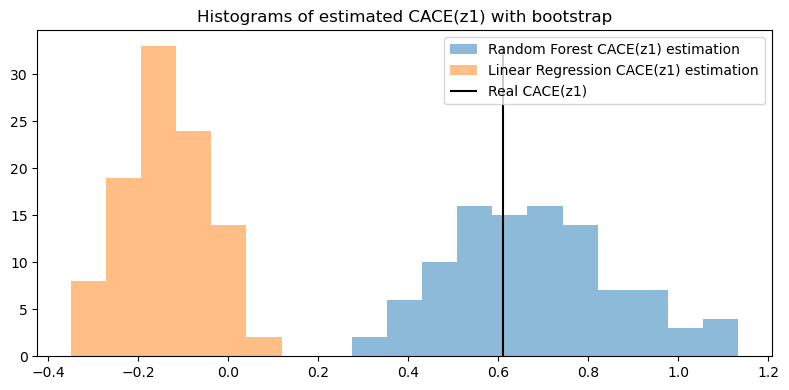

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

min_cace = min(min(cace_distribution_rfr), min(cace_distribution_lr))
max_cace = max(max(cace_distribution_rfr), max(cace_distribution_lr))

hist_rfr, _, _ = ax.hist(cace_distribution_rfr, bins=np.linspace(min_cace, max_cace, 20), alpha=0.5, label="Random Forest CACE(z1) estimation")
hist_lr, _, _ = ax.hist(cace_distribution_lr, bins=np.linspace(min_cace, max_cace, 20), alpha=0.5, label="Linear Regression CACE(z1) estimation")

min_hist = min(min(hist_rfr), min(hist_lr))
max_hist = max(max(hist_rfr), max(hist_lr))
ax.vlines(ground_truth_X_true(z1) - ground_truth_X_false(z1), min_hist, max_hist, "k", label="Real CACE(z1)")

ax.legend()
ax.set_title("Histograms of estimated CACE(z1) with bootstrap")
plt.tight_layout()

Because linear regression isn't great at guessing the non-linear conditional expectations, it's only natural that it's not so hot at predicting effects that rely on those guesses.

___